# Image Data Augmentation and Normalization Notebook


This notebook will run you through a real world example of image data augmentation and normalization.

Let's first import some libraries. 

In [82]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np

In addition, let's define some helpful tools and models. We will do all the heavy work of writing the neural net model definition, loading the dataset, and the training pipeline, as well as some visualization tools. For this assignment, we will be using VGG, a state of the art neural net circa 2014 used for image classification, and CIFAR10, a 10 class image classification dataset.



In [13]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())



In [15]:
test()

torch.Size([2, 10])


In [116]:
def loadData(transform, train, batch_size):

  dir = './data/train' if train else './data/val'
  dataset = torchvision.datasets.CIFAR10('./data/train', 
                                             transform = transform,
                                             train = train, 
                                             download=True)

  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train)
  return loader

In [110]:
def train(net, criterion, epoch, optimizer, train_loader):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print('Training Loss: %.3f | Acc: %.3f%% (%d/%d)'  
            % (train_loss/(batch_idx+1), 
            100.*float(correct)/float(total), correct, total))

def val(net, criterion, epoch, optimizer, val_loader, best_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(val_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print('Validation Loss: %.3f | Acc: %.3f%% (%d/%d)'  
            % (test_loss/(batch_idx+1), 
            100.*float(correct)/float(total), correct, total))

    acc = 100.*float(correct)/float(total)
    if acc > best_acc:
        best_acc = acc
    return best_acc

In [111]:
def runTraining(train_transform, val_transform):
    #load data
    print('loading data...')

    train_loader = loadData(train_transform, True, 128)
    val_loader = loadData(val_transform, False, 128)
    
    #set up net
    print('setting up net...')
    net = VGG('VGG11')
    
    #set up cuda
    print('setting up cuda...')
    net.cuda()
    net = nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

    #set up training
    print('setting up training...')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
            net.parameters(), 
            lr=1e-2, 
            momentum=0.9, 
            weight_decay=1e-4) #can be changed in optional part
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=[4], gamma=0.1) #can be changed in optional part

    start_epoch = 0
    max_epoch = 10 #can be changed in optional part
    best_acc = 0

    #run one round of inference before beginning testing
    print('running pre-training inference...')
    best_acc = val(net, criterion, start_epoch, optimizer, val_loader, best_acc)

    #training
    print('starting training...')
    start_epoch += 1
    max_epoch += 1
    for epoch in range(start_epoch, max_epoch):
        train(net, criterion, epoch, optimizer, train_loader)
        scheduler.step()
        best_acc = val(net, criterion, epoch, optimizer, val_loader, best_acc)



In [137]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [138]:
def showKImgs(transform, k):
  # get some random training images
  loader = loadData(transform, True, k)

  dataiter = iter(loader)
  images, labels = dataiter.next()

  # create grid of images
  img_grid = torchvision.utils.make_grid(images)

  # show images
  matplotlib_imshow(img_grid, one_channel=False)


Let's first define a dummy transform. This transform performs no augmentation except for the necessary task of converting the PIL images to tensors.

In [139]:
val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])


Use the provided functions to visualize the first couple of images in the training dataset. We will be using the CIFAR10 dataset (this is already written for you, don't worry about it). 

Files already downloaded and verified


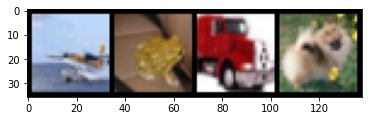

In [140]:
#begin student code
showKImgs(train_transform, 4)
#end student code 

Here is the pytorch transforms documentation: https://pytorch.org/docs/stable/torchvision/transforms.html. Image transforms such as crops, flips, shifts, etc. should only ever be applied to the train set, as applying them to the val set as well defeats the purpose of augmenting the dataset in the first place. Try to use one of the functions in there to perform a random horizontal flip of the images, then visualize it. 

Files already downloaded and verified


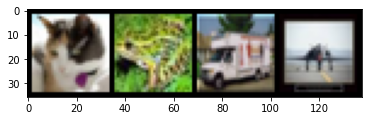

In [141]:
#begin student code
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
showKImgs(train_transform, 4)
#end student code

In addition to image transforms, we may want to normalize or standardize the images. These need to be applied to both the val and train sets. Try normliazing the images, then visualize it. 

Files already downloaded and verified


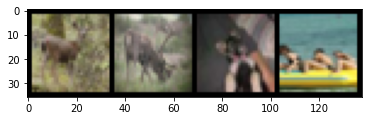

In [142]:
#begin student code
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ])
showKImgs(train_transform, 4)
#end student code

As a baseline, we will see how well VGG performs on CIFAR10 without any augmentation. Write a dummy transform with no augmentation and use the given functions to run the training (this should take roughly 30 seconds per epoch for a total of roughly 5 minutes).

In [144]:
#begin student code
val_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
runTraining(train_transform, val_transform)
#end student code

loading data...
Files already downloaded and verified
Files already downloaded and verified
setting up net...
setting up cuda...
setting up training...
running pre-training inference...



Validation Loss: 2.303 | Acc: 10.000% (1000/10000)
starting training...

Epoch: 1



Training Loss: 1.245 | Acc: 55.580% (27790/50000)



Validation Loss: 1.261 | Acc: 56.260% (5626/10000)

Epoch: 2



Training Loss: 0.767 | Acc: 73.192% (36596/50000)



Validation Loss: 0.996 | Acc: 66.430% (6643/10000)

Epoch: 3



Training Loss: 0.578 | Acc: 80.024% (40012/50000)



Validation Loss: 0.692 | Acc: 76.700% (7670/10000)

Epoch: 4



Training Loss: 0.441 | Acc: 84.694% (42347/50000)



Validation Loss: 0.899 | Acc: 71.330% (7133/10000)

Epoch: 5



Training Loss: 0.185 | Acc: 94.054% (47027/50000)



Validation Loss: 0.537 | Acc: 82.880% (8288/10000)

Epoch: 6



Training Loss: 0.111 | Acc: 96.606% (48303/50000)



Validation Loss: 0.563 | Acc: 83.400% (8340/10000)

Epoch: 7



Training Loss: 0.070 | Acc: 98.048% (49024/50000)



Validation Loss: 0.607 | Acc: 83.360% (8336/10000)

Epoch: 8



Training Loss: 0.040 | Acc: 99.096% (49548/50000)



Validation Loss: 0.651 | Acc: 83.680% (8368/10000)

Epoch: 9



Training Loss: 0.022 | Acc: 99.630% (49815/50000)



Validation Loss: 0.701 | Acc: 83.280% (8328/10000)

Epoch: 10



Training Loss: 0.013 | Acc: 99.878% (49939/50000)



Validation Loss: 0.728 | Acc: 83.390% (8339/10000)


As a sanity check, you should have gotten roughly 82% final val accuracy. Notice the large gap in val accuracy and train accuracy, which should be nearly saturated at 99%+. More importantly, notice that at around epoch 5, we reach the minimum val loss at around 0.5, but we actually get much worse as we keep training because our model fits more and more towards the training data, which is not robust enough.

Now, you will compose your own train_transform function and use it to train with your augmented dataset. Fill in the following cell and run the training (this will take a little longer, as applying the transforms for each image takes up some time as well).

You can look at some preprocessing practices in section 4.1 of this classic paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

as well as section 3.4 of this other classic paper:
 https://arxiv.org/pdf/1512.03385.pdf

Hint: check to make sure the final size of your images after the transform is done matches the expected input size from CIFAR10.

The pytorch transforms documentation for your convenience: https://pytorch.org/docs/stable/torchvision/transforms.html

In [77]:
#begin student code
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ])
final_train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ])
runTraining(final_train_transform, val_transform)
#end student code

loading data...
Files already downloaded and verified
Files already downloaded and verified
setting up net...
setting up cuda...
setting up training...
running pre-training inference...



Validation Loss: 2.303 | Acc: 10.000% (1000/10000)
starting training...

Epoch: 1



Training Loss: 1.388 | Acc: 50.034% (25017/50000)



Validation Loss: 1.465 | Acc: 51.510% (5151/10000)

Epoch: 2



Training Loss: 0.948 | Acc: 66.488% (33244/50000)



Validation Loss: 0.903 | Acc: 68.620% (6862/10000)

Epoch: 3



Training Loss: 0.768 | Acc: 72.922% (36461/50000)



Validation Loss: 0.991 | Acc: 66.510% (6651/10000)

Epoch: 4



Training Loss: 0.673 | Acc: 76.584% (38292/50000)



Validation Loss: 0.860 | Acc: 70.820% (7082/10000)

Epoch: 5



Training Loss: 0.495 | Acc: 82.844% (41422/50000)



Validation Loss: 0.493 | Acc: 83.070% (8307/10000)

Epoch: 6



Training Loss: 0.451 | Acc: 84.268% (42134/50000)



Validation Loss: 0.493 | Acc: 83.360% (8336/10000)

Epoch: 7



Training Loss: 0.432 | Acc: 84.928% (42464/50000)



Validation Loss: 0.483 | Acc: 83.490% (8349/10000)

Epoch: 8



Training Loss: 0.412 | Acc: 85.614% (42807/50000)



Validation Loss: 0.476 | Acc: 84.070% (8407/10000)

Epoch: 9



Training Loss: 0.401 | Acc: 86.044% (43022/50000)



Validation Loss: 0.480 | Acc: 83.720% (8372/10000)

Epoch: 10



Training Loss: 0.386 | Acc: 86.550% (43275/50000)



Validation Loss: 0.505 | Acc: 83.200% (8320/10000)


You should have gotten a relatively similar final val accuracy. However, if you've done this correctly, you should notice that the final train accuracy is also rather low, at around 85% or so. This means our model has not saturated train performance yet, so if we were to continue training it, it has room for improvement, which should also improve the val accuracy (we won't make you sit through this, as fully training out neural networks for real life performance takes many epochs and compute hours, and the payoffs are diminishing in return the longer you train). In short, our model is a lot less weak to overfitting on the training data.

As an optional extra exercise, the canonical performance for VGG on CIFAR10 is around 92%. See if you can play around with different data transform options to come somewhere near that performance. You will probably need to tune some hyperparameters as well, such as the LRScheduler, LR, weight decay, epochs, etc.